 # Two high-level analyses:
 - Classify users into 'bad' vs 'good'--users with precision < 65% and users >= 65%

 For github issues and brainstorming features and analyses, use github:
 - https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

### Table of Contents
* [Intersection Proximity](#Intersection-Proximity)
* [CV Analysis](#CV-Analysis)
* [Population Density](#Population-Density)
* [Zone type](#Zone-type)
* [Classification](#Classification)
* [Analysis of min labels vs. precision](#Analysis-of-min-labels-vs.-precision)
* [DC Classificaton](#DC-Classification)

In [1]:
import sys
import time
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse as str_parse
import seaborn as sns
import sklearn.feature_selection
from dateutil import parser as parser
from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               EasyEnsembleClassifier)
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import linear_model, svm, tree
from sklearn.base import BaseEstimator
from sklearn.ensemble import (BaggingClassifier, BaggingRegressor,
                              ExtraTreesClassifier, ExtraTreesRegressor,
                              RandomForestClassifier, VotingClassifier, RandomForestRegressor)
from sklearn.feature_selection import RFECV, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                             r2_score, recall_score)
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import multiprocessing as mp
import warnings
import intersection_proximity
from region_stats import RegionStats
import scipy


Using TensorFlow backend.


Load all the user information and label correctness

In [4]:
# users = pd.read_csv('ml-users.csv')
users = pd.read_csv('users_one_mission.csv')
users = users.set_index('user_id')
 
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)
 
# label_correctness = pd.read_csv('ml-label-correctness.csv')
label_correctness = pd.read_csv('ml-label-correctness-one-mission.csv')
 
label_correctness.set_index('label_id', inplace=True)
 
label_correctness = label_correctness.join(point_labels)
 
label_correctness = label_correctness[['user_id', 'label_type', 
    'correct', 'sv_image_x', 'sv_image_y', 'canvas_x', 'canvas_y', 
    'heading', 'pitch', 'zoom', 'lat', 'lng']]

 
users_for_analysis = users.index[users['labels_validated'] > 0]
label_correctness = label_correctness[label_correctness['user_id'].isin(users_for_analysis)]
users = users.loc[users_for_analysis]
 
label_correctness.update(label_correctness['correct'][~pd.isna(label_correctness['correct'])] == 't')
 
label_type_encoder = OrdinalEncoder()
 
label_correctness['label_type'] = label_type_encoder.fit_transform(label_correctness[['label_type']])


 # Intersection Proximity

Load intersection proximity for each label

proximity_distance is the absolute distance to the nearest intersection

proximity_middleness is the "middleness" as measured in the intersection proximity library

In [5]:
ip = intersection_proximity.IntersectionProximity(intersection_proximity.default_settings['seattle'])

In [7]:
def get_proximity_info(label):
    try:
        distance, middleness = ip.compute_proximity(label.lat, label.lng, cache=True)
    except Exception:
        distance = -1
        middleness = -1
    
    return pd.Series({
        'proximity_distance': distance,
        'proximity_middleness': middleness
    })

label_correctness = label_correctness.join(label_correctness.apply(get_proximity_info, axis=1))


 # CV Analysis


This is the full analysis of using CV predictions for classifying labels.

We found that it's not very useful.

In [8]:
cv_predictions = pd.read_csv('summary_user.csv').rename(columns={
    'CVLabel': 'cv_label_type',
    'Confidence': 'cv_confidence'
},)

In [9]:
label_types = ['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem']


In [8]:
label_correctness = label_correctness.join(cv_predictions)

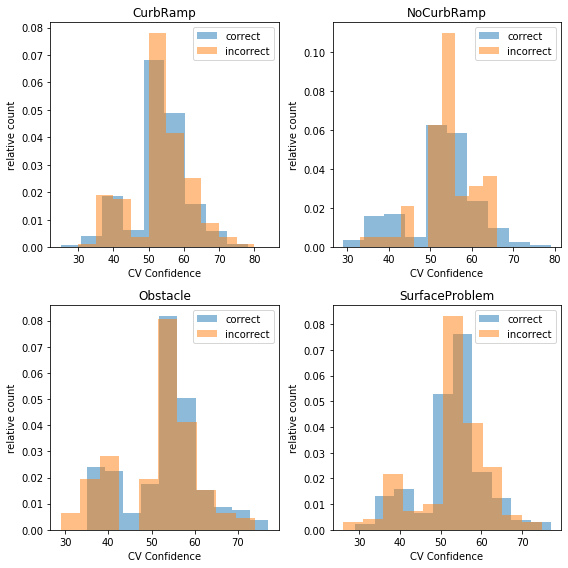

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = label_correctness[~pd.isna(label_correctness['correct']) & ~pd.isna(label_correctness['cv_confidence']) & (label_correctness['label_type'] == label_encoded)]
    ax.set_xlabel('CV Confidence')
    ax.set_ylabel('relative count')
    ax.set_title(label_types[i])
    ax.hist(selection[selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='correct', density=True)
    ax.hist(selection[~selection['correct'].astype(bool)]['cv_confidence'], alpha=0.5, label='incorrect', density=True)
    ax.legend()

fig.tight_layout()

In [8]:
label_correctness.loc[:, 'cv_label_type'][~pd.isna(label_correctness.loc[:, 'cv_label_type'])] = \
    label_type_encoder.transform(pd.DataFrame(label_correctness.loc[:, 'cv_label_type'][~pd.isna(label_correctness.loc[:, 'cv_label_type'])]))

/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
prob = np.zeros((4, 4))
for i in range(len(label_types)):
    for j in range(len(label_types)):
        i_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
        j_encoded = label_type_encoder.transform([[label_types[j]]])[0][0]

        selection = label_correctness[~pd.isna(label_correctness['correct']) 
            & (label_correctness['label_type'] == i_encoded)
            & (label_correctness['cv_label_type'] == j_encoded)]
        
        try:
            prob[i][j] = np.sum(selection['correct']) / len(selection)
        except ZeroDivisionError:
            prob[i][j] = np.nan

prob

array([[0.93716338, 0.88888889, 0.78484848, 0.78034682],
       [0.93197279, 0.87037037, 0.86065574, 0.91139241],
       [0.75824176, 0.65384615, 0.61728395, 0.53731343],
       [0.68444444, 0.59090909, 0.75      , 0.60606061]])

 # Population Density

Analysis of population density as a feature. It has some correlation with accuracy

In [10]:
rs = RegionStats('data_seattle.geojson')
label_correctness = label_correctness.join(
    label_correctness.apply(lambda x: pd.Series(rs.get_properties(x.lng, x.lat)), axis=1)
)

In [11]:
selection_all = label_correctness[['density', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]

/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


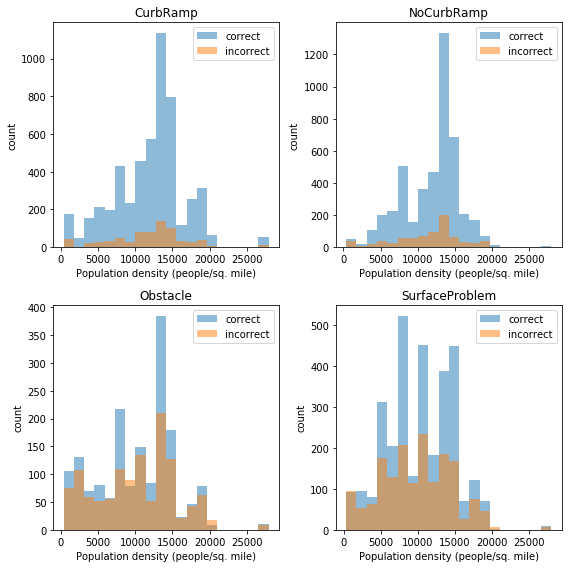

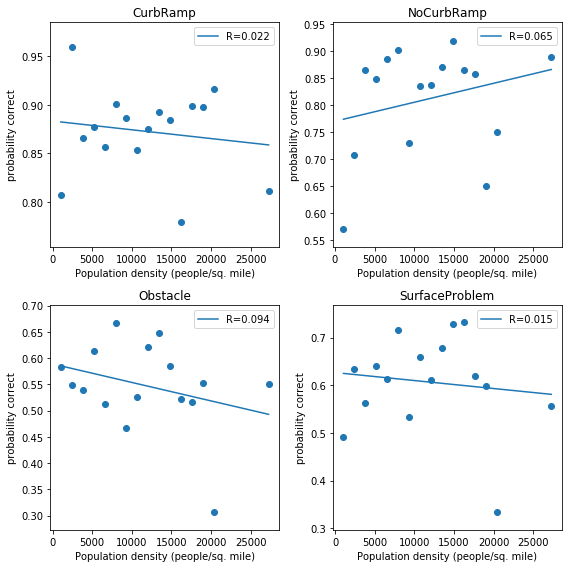

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    ax.set_xlabel('Population density (people/sq. mile)')
    ax.set_ylabel('count')
    ax.set_title(label_types[i])
    nc, bins, _ = ax.hist(selection[selection['correct'] == True]['density'], density=False, bins=20, alpha=0.5, label='correct')
    ni, _, _ = ax.hist(selection[selection['correct'] == False]['density'], density=False, bins=bins, alpha=0.5, label='incorrect')
    ax.legend()

    ax2 = axes2[i//2][i%2]
    ax2.set_xlabel('Population density (people/sq. mile)')
    ax2.set_ylabel('probability correct')
    ax2.set_title(label_types[i])
    density_vals = (bins[:-1] + bins[1:])/2
    correct_prob = nc / (ni + nc)
    mask = ~np.isnan(correct_prob)
    density_vals = density_vals[mask]
    correct_prob = correct_prob[mask]
    ax2.scatter(density_vals, correct_prob)

    
    z = np.polyfit(density_vals, correct_prob, 1)
    p = np.poly1d(z)
    ax2.plot(density_vals, p(density_vals), 
    label=f"R={r2_score(correct_prob, p(density_vals)):.3f}")

    ax2.legend()


fig.tight_layout()
fig2.tight_layout()


 # Zone type

Zone type is even better.

In [11]:
rs = RegionStats('Zoning_Detailed.geojson')
label_correctness = label_correctness.join(
    label_correctness.apply(lambda x: pd.Series(rs.get_properties(x.lng, x.lat)), axis=1)
)


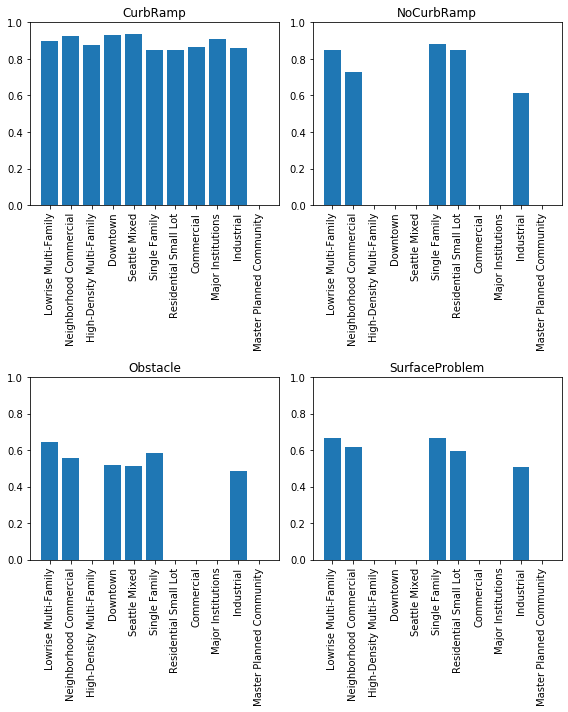

In [14]:
selection_all = label_correctness[['CATEGORY_DESC', 'correct', 'label_type']]
selection_all = selection_all[~pd.isna(selection_all).any(axis=1)]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 10))
categories = selection_all['CATEGORY_DESC'].unique()

for i in range(len(label_types)):
    ax = axes[i//2][i%2]
    label_encoded = label_type_encoder.transform([[label_types[i]]])[0][0]
    selection = selection_all[selection_all['label_type'] == label_encoded]
    # ax.set_xlabel('Population density (people/sq. mile)')
    # ax.set_ylabel('count')
    ax.set_title(label_types[i])
    prob_correct = dict()
    for category in categories:
        if np.sum(selection['CATEGORY_DESC'] == category) > 100:
            prob_correct[category] = np.mean(selection['correct'][selection['CATEGORY_DESC'] == category])
        else:
            prob_correct[category] = 0
        # num_in[category] = np.sum(selection['CATEGORY_DESC'] == category)

    ax.bar(prob_correct.keys(), prob_correct.values())
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelrotation=90)

fig.tight_layout()

 # Classification

This is the basic pipeline for classification:

The set of training users is split, 35% into a training set for the label classifier and 65% into a testing set for the accuracy classifier.

All the label validations from the 35% are used to train the classifier, using the features in `features`.

Then, the label classifier predicts p(correct) for all the labels in the 65% set. `prob_hist` is used to extract a small number of features from the list of probabilities.

The accuracy classifier is trained on the features from `prob_hist` + the user features generated in Tyler's notebook for the 65% set.

To test the final classifier, we do the same as the 65% test, but with just the testing users: we pass the results of the label classifier into `prob_hist`, add the features from Tyler's notebook, and then pass that in to the accuracy classifier.

In [12]:
def prob_hist(probabilities, n_bins=5):
    return [np.mean(probabilities), np.std(probabilities),
        np.percentile(probabilities, 25), np.percentile(probabilities, 50),
        np.percentile(probabilities, 75), np.mean(probabilities[(probabilities > 0.25) | (probabilities < 0.75)])]
def dearray(array):
    return np.array([list(l) for l in array])


 Load Tyler's features (see his notebook)

In [13]:
user_quality_features = pd.read_csv('all_users.csv')
user_quality_features.set_index('user_id', inplace=True)
# user_quality_features.set_index('Unnamed: 0', inplace=True)

In [14]:
users_filtered = users[users['labels_validated'] > 25]

In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [26]:
mode = 'classification'
# mode = 'regression'

In [27]:
features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng', 'proximity_distance', 'proximity_middleness', 'CLASS_DESC', 'ZONEID']

proportion_labels = 0.35
comparisons = pd.DataFrame()
split_num = 0
np.random.seed(0)

for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users_filtered.index):
    X_train, X_test = users_filtered.index[train_index], users_filtered.index[test_index]
    
    if mode == 'classification':
        y_train, y_test = users_filtered['accuracy'][train_index] > 65, users_filtered['accuracy'][test_index] > 65
    else:
        y_train, y_test = users_filtered['accuracy'][train_index], users_filtered['accuracy'][test_index]

#     y_train, y_test = users_filtered['missions_completed'][train_index] > 6, users_filtered['missions_completed'][test_index] > 6

    mask = np.random.permutation(np.arange(len(X_train)))
    users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
    users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

    train_labels = label_correctness[label_correctness['user_id'].isin(X_train)].copy()
    test_labels = label_correctness[label_correctness['user_id'].isin(X_test)].copy()
    #%%
    test_labels = test_labels.drop(columns='correct')
    #%%
    train_labels = train_labels[~pd.isna(train_labels['correct'])]
    train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
    test_labels = test_labels[~(pd.isna(test_labels[features]).any(axis=1))]
    # scaler = StandardScaler()
    # train_labels[features] = scaler.fit_transform(train_labels[features])
    
    en = OrdinalEncoder()
    en.fit(pd.concat((train_labels[['CLASS_DESC']], test_labels[['CLASS_DESC']])))
    train_labels[['CLASS_DESC']] = en.transform(train_labels[['CLASS_DESC']])
    test_labels[['CLASS_DESC']] = en.transform(test_labels[['CLASS_DESC']])

    #%%
    rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
           scoring='precision')
    clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=30)
    # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
    rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
    
    if mode == 'classification':
        clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=30)
        rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
        
    else:
        clf_accuracy = BaggingRegressor(random_state=0, n_jobs=-1, n_estimators=30)
        rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')

    # clf = BalancedRandomForestClassifier(random_state=0)  
    
    # TODO don't eliminate all nans

    #%%
    # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    print('Training label classifier...')
    rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
        train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))
    
    train_labels = train_labels.join(pd.Series(
        data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
        index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')
    
    prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
        .groupby('user_id').apply(lambda x:\
        prob_hist(x['prob'].values)).rename('prob'))
    
    prob_hist_predictions = prob_hist_predictions.join(user_quality_features)
    
    print('Training accuracy classifier...')
    if mode == 'classification':
        rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1), 
            y_train.loc[prob_hist_predictions.index])
    else:
        rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1), 
            y_train.loc[prob_hist_predictions.index] > 65)
    
    clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
        prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
        y_train.loc[prob_hist_predictions.index])
    #%%
    # Probabililty correct
    useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
    # useful_test[features] = scaler.transform(useful_test[features])
    # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
    useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

    # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
    # break
    #%%

    # Now predict accuracy

    def predict_accuracy(probs, features):
        # fig = plt.figure()
        # plt.xlim(0, 1)
        # plt.hist(probs)
        
        # selected_probs = probs[~np.isnan(probs)]
        # return np.mean(selected_probs)
        # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
        return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]
    
    print('Making predictions...')
    mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

    #%%
    comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
    comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
    comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
    comparisons = comparisons.append(comparison)

    #%%

    split_num += 1

    # sys.stderr.write(f'{split_num} / 5\n')

# comparisons['accuracy'] = (comparisons['accuracy']).astype(int)

if mode == 'classification':
    mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
    print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...
Training label classifier...
Training accuracy classifier...
Making predictions...


ValueError: unknown is not supported

If running a regression, use this to view the results

In [22]:
comparisons = comparisons[~pd.isna(comparisons[['predicted', 'accuracy']]).any(axis=1)]

In [23]:
comparisons['predicted'].max()

87.38165193249529

In [110]:
sum(users['labels_validated'] > 25)

112

ValueError: array must not contain infs or NaNs

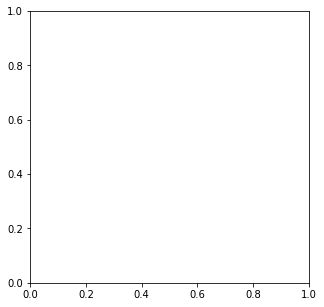

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
r2 = scipy.stats.pearsonr(comparisons['accuracy'], comparisons['predicted'])
ax.scatter(comparisons['predicted'], comparisons['accuracy'], )
z = np.polyfit(comparisons['predicted'],comparisons['accuracy'], 1)
w = np.poly1d(z)
ax.plot(comparisons['predicted'], w(comparisons['predicted']), color='red', label=f'R={r2[0]:.3f}\n')
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.set_xlabel('predicted accuracy')
ax.set_ylabel('actual accuracy')
ax.legend()


View the results of RFE using this. You can change `rfe` to either `rfe_labels` or `rfe_accuracy`

Optimal number of features : 44
Optimal number of features : [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True False False  True  True False
  True False False  True False  True False  True  True  True  True  True
  True  True False  True  True False False]


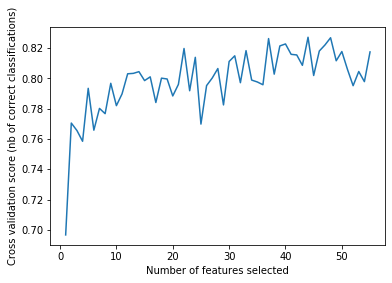

In [211]:
# rfe = rfe_accuracy
print("Optimal number of features : %d" % rfe.n_features_)
print("Optimal number of features : %s" % str(rfe.support_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

# Analysis of min labels vs. precision

This takes about 30 mins to run. but there are some generated plots in GitHub. We found that >45 validated labels is optimal for the performance of the classifier

In [25]:
def get_p_r(users, label_correctness):
    features = ['label_type', 'sv_image_y', 'canvas_x', 'canvas_y', 'heading', 'pitch', 'zoom', 'lat', 'lng',]
    proportion_labels = 0.1
    comparisons = pd.DataFrame()
    split_num = 0
    np.random.seed(0)

    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(users.index):
        X_train, X_test = users.index[train_index], users.index[test_index]
        y_train, y_test = users['accuracy'][train_index], users['accuracy'][test_index]

        mask = np.random.permutation(np.arange(len(X_train)))
        users_labels_train = X_train[mask[:int(proportion_labels * len(mask))]]
        users_labels_test = X_train[mask[int(proportion_labels * len(mask)):]]

        train_labels = label_correctness[label_correctness['user_id'].isin(X_train)]
        test_labels = label_correctness[label_correctness['user_id'].isin(X_test)]
        #%%
        test_labels = test_labels.drop(columns='correct')
        #%%
        train_labels = train_labels[~pd.isna(train_labels['correct'])]
        train_labels = train_labels[~(pd.isna(train_labels[features]).any(axis=1))]
        # scaler = StandardScaler()
        # train_labels[features] = scaler.fit_transform(train_labels[features])

        #%%
        rfe_labels = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
               scoring='precision')
        clf_labels = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=10)
        # clf_accuracy = BalancedBaggingClassifier(n_jobs=-1, random_state=0, n_estimators=100)
        rfe_accuracy = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5), scoring='f1')
        clf_accuracy = BalancedBaggingClassifier(random_state=0, n_jobs=-1, n_estimators=20)
        # clf = BalancedRandomForestClassifier(random_state=0)  

        # TODO don't eliminate all nans

        #%%
        # clf_labels.fit(train_labels[features], train_labels['correct'].astype(int))
    #     print('Training label classifier...')
        rfe_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values, 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        clf_labels.fit(train_labels[train_labels['user_id'].isin(users_labels_train)][features].values[:, rfe_labels.support_], 
            train_labels[train_labels['user_id'].isin(users_labels_train)]['correct'].astype(int))

        train_labels = train_labels.join(pd.Series(
            data=clf_labels.predict_proba(train_labels[train_labels['user_id'].isin(users_labels_test)][features].values[:, rfe_labels.support_])[:, 1], 
            index=train_labels[train_labels['user_id'].isin(users_labels_test)].index).rename('prob'), how='outer')

        prob_hist_predictions = pd.DataFrame(train_labels[train_labels['user_id'].isin(users_labels_test)]
            .groupby('user_id').apply(lambda x:\
            prob_hist(x['prob'].values)).rename('prob'))

        prob_hist_predictions = prob_hist_predictions.join(user_quality_features)

    #     print('Training accuracy classifier...')
        rfe_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1), 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))

        clf_accuracy.fit(np.concatenate((dearray(prob_hist_predictions['prob']), 
            prob_hist_predictions.drop(columns='prob').values), axis=1)[:, rfe_accuracy.support_], 
            (y_train.loc[prob_hist_predictions.index] > 65).astype(int))
        #%%
        # Probabililty correct
        useful_test = test_labels[~pd.isna(test_labels[features]).any(axis=1)].copy()  # TODO don't eliminate all nans
        # useful_test[features] = scaler.transform(useful_test[features])
        # useful_test = useful_test.join(useful_test.apply(get_proximity_info, axis=1))
        useful_test.loc[:, 'prob'] = clf_labels.predict_proba(useful_test[features].values[:, rfe_labels.support_])[:, 1]

        # a = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob']))
        # break
        #%%

        # Now predict accuracy

        def predict_accuracy(probs, features):
            # fig = plt.figure()
            # plt.xlim(0, 1)
            # plt.hist(probs)

            # selected_probs = probs[~np.isnan(probs)]
            # return np.mean(selected_probs)
            # return clf_accuracy.predict_proba([np.concatenate((prob_hist(probs), features))])[:, 1][0]
            return clf_accuracy.predict([np.concatenate((prob_hist(probs), features))[rfe_accuracy.support_]])[0]

    #     print('Making predictions...')
        mean_probs = useful_test.groupby('user_id').apply(lambda x: predict_accuracy(x['prob'].values, user_quality_features.loc[x.name])).rename('predicted')

        #%%
        comparison = pd.DataFrame((mean_probs, y_test, pd.Series(np.full((len(y_test)), split_num), name='split_num', index=y_test.index))).T
        comparison['prob_hist'] = useful_test.groupby('user_id').apply(lambda x: prob_hist(x['prob'].values))
        comparison['probs'] = useful_test.groupby('user_id').apply(lambda x: x['prob'].values)
        comparisons = comparisons.append(comparison)

        #%%

        split_num += 1

        # sys.stderr.write(f'{split_num} / 5\n')

    comparisons['accuracy'] = (comparisons['accuracy'] > 65).astype(int)

    mask = ~pd.isna(comparisons[['accuracy', 'predicted']]).any(axis=1)
    # print(precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(accuracy_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]))
    # print(confusion_matrix(comparisons['accuracy'][mask], comparisons['predicted'][mask]))

    return precision_score(comparisons['accuracy'][mask], comparisons['predicted'][mask]), recall_score(comparisons['accuracy'][mask], comparisons['predicted'][mask])


In [ ]:
%%time
warnings.filterwarnings('ignore')
def run_range(min_labels):
    try:
        print(min_labels)
        users_for_analysis = users.index[users['labels_validated'] > min_labels]
        users2 = users.loc[users_for_analysis]
        return get_p_r(users2, label_correctness)
    except Exception:
        return (-1, -1)
    
with mp.Pool(4) as p:
    results = p.map(run_range, np.arange(1,75))

In [ ]:
results = np.array(results)

In [ ]:
results_with_min = np.concatenate((np.arange(2, 76).reshape(-1, 1), results), axis=1)
results_invalid = results_with_min[~(results == -1).any(axis=1)]
results_df = pd.DataFrame(data=results_invalid, columns=('min', 'precision', 'recall')).set_index('min')

In [ ]:
results_df = results_df.iloc[results_df.index < 45]

In [ ]:
plt.figure()
# plt.scatter(results_df.index, results_df['precision'])
plt.scatter(results_df.index, results_df['recall'])
# plt.scatter(results_df.index, 2/(1/results_df['precision'] + 1/results_df['recall']))
plt.xlabel('min number of labels')
plt.ylabel('recall')

In [ ]:
results[44]

In [ ]:
get_p_r

In [ ]:
fig = plt.figure()
plt.vlines(np.arange(len(users['labels_validated'])), 0, np.sort(users['labels_validated'])[::-1], color='C0')
plt.axis((0, None, 0, None))
plt.xlabel('user number')
plt.ylabel('number of validated labels')
fig.savefig('a.svg')

In [ ]:
np.sort(users['labels_validated'])[::-1]

# DC Classification

Our attempts at classifying DC data. It didn't go very well (~55% p/r using the same features as Seattle)

In [37]:
dc_features = pd.read_csv('all_users_dc_with_interaction.csv')
dc_users = pd.read_csv('all_users_outputs_dc_with_interaction.csv')

In [39]:
dc_features.set_index("Unnamed: 0", inplace=True)
dc_users.set_index("Unnamed: 0", inplace=True)

In [80]:
import scipy

In [87]:
'R = ' + str(f'{pears[0]:.2f}')

'R = 0.08'

R = 0.37
R = 0.33
R = -0.32
R = 0.34
R = 0.40
R = 0.02
R = -0.03
R = -0.04
R = -0.07
R = 0.25
R = -0.04
R = 0.25
R = 0.25
R = 0.08
R = 0.11
R = 0.29
R = 0.10


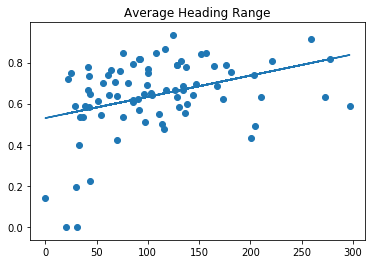

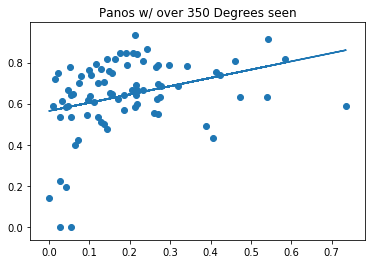

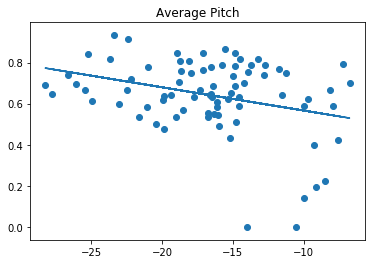

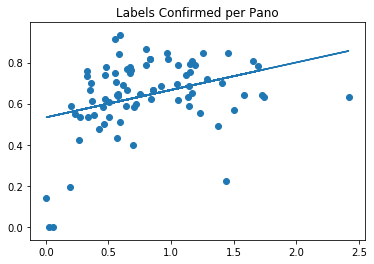

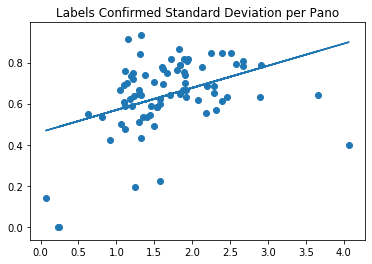

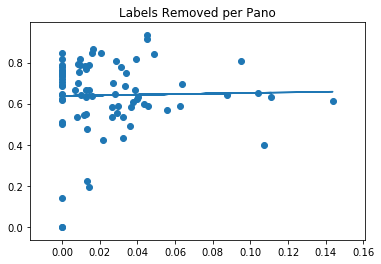

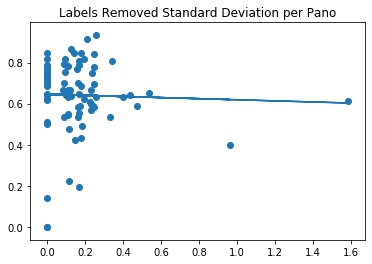

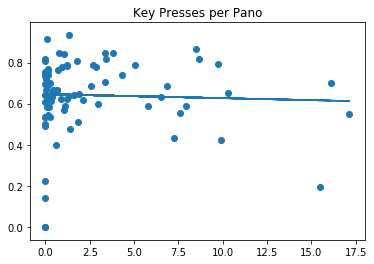

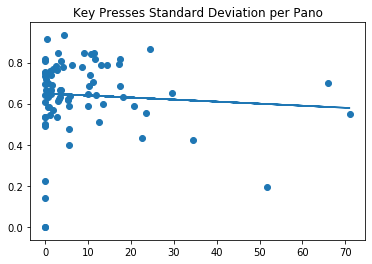

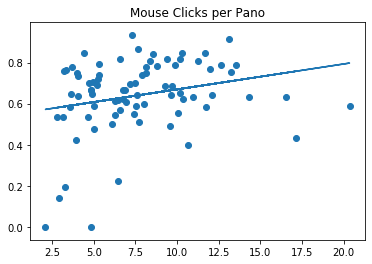

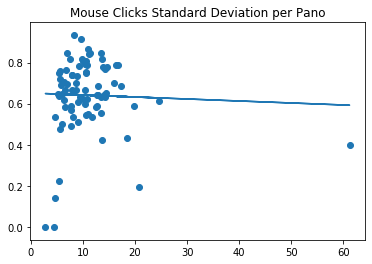

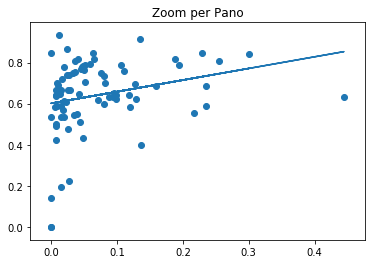

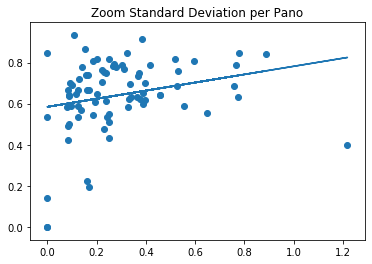

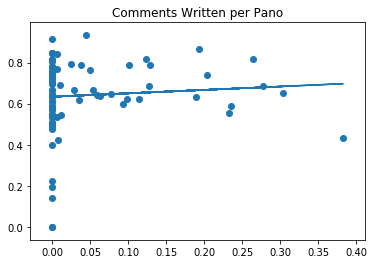

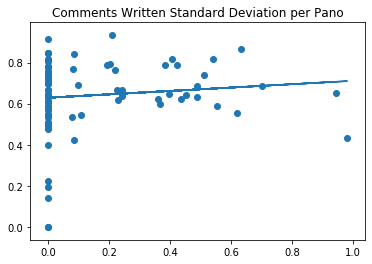

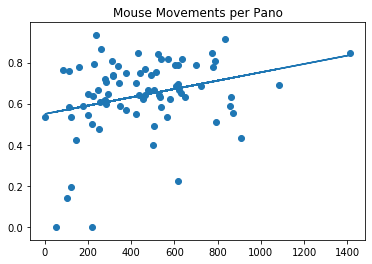

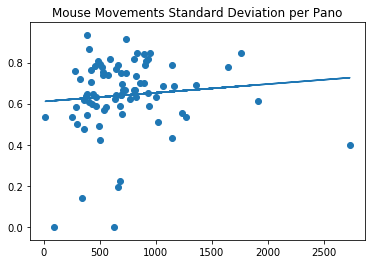

In [91]:
for x in dc_features.columns:
    if 'Tag' not in x:
        plt.figure()
        plt.title(x)
        z = np.polyfit(dc_features[x],dc_users['f1'], 1)
        w = np.poly1d(z)
        pears = scipy.stats.pearsonr(dc_features[x],dc_users['f1'])
        plt.scatter( dc_features[x],dc_users['f1'])
        plt.plot(dc_features[x], w(dc_features[x]))
        print('R = ' + str(f'{pears[0]:.2f}'))

In [90]:
dc_users['f1'] = 2 / (1/dc_users['precision'] + 1/dc_users['recall'])

In [92]:
dc_users['good'] = (dc_users['f1'] > 0.65)

In [95]:
np.median(dc_users['f1'])

0.658333333106736

In [96]:
from sklearn.dummy import DummyClassifier

In [108]:
comparisons = pd.DataFrame()
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(dc_users.index):
    X_train, X_test = dc_features.iloc[train_index], dc_features.iloc[test_index]
    y_train, y_test = dc_users['good'].iloc[train_index], dc_users['good'].iloc[test_index]
    
#     rfe = RFECV(estimator=RandomForestClassifier(n_estimators=10), step=1, cv=StratifiedKFold(5),
#            scoring='f1')
    
#     rfe.fit(X_train, y_train)
#     clf = RandomForestClassifier(random_state=0, n_estimators=10)
    clf = BalancedRandomForestClassifier(random_state=0, n_estimators=10)
#     clf.fit(X_train.values[:, rfe.support_], y_train)
    clf.fit(X_train.values, y_train)

    comparisons = comparisons.append(pd.DataFrame(
#         data=np.stack((clf.predict(X_test.values[:, rfe.support_]).reshape(-1), y_test.values.reshape(-1)), axis=1), 
        data=np.stack((clf.predict(X_test.values).reshape(-1), y_test.values.reshape(-1)), axis=1), 
        columns=('predicted', 'actual'))
    )

comparisons.reset_index(inplace=True, drop=True)

In [109]:
mask = ~pd.isna(comparisons[['actual', 'predicted']]).any(axis=1)
print(precision_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(recall_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(accuracy_score(comparisons['actual'][mask], comparisons['predicted'][mask]))
print(confusion_matrix(comparisons['actual'][mask], comparisons['predicted'][mask]))

0.5510204081632653
0.675
0.5625
[[18 22]
 [13 27]]


Optimal number of features : 14
Optimal number of features : [ True  True  True False False  True  True  True  True  True  True False
  True  True  True False False  True  True]


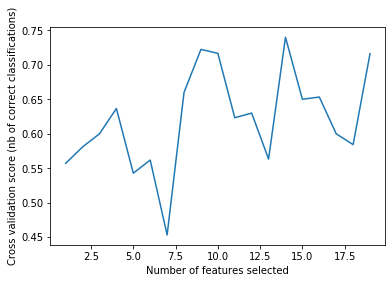

In [102]:
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.print("Optimal number of features : %d" % rfe.n_features_)
print("Optimal number of features : %s" % str(rfe.support_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()


# Analysis of number of panos vs. classifier precisison

In [3]:
all_users_lists = pd.read_pickle('all_users_lists_new')

In [14]:
all_users_lists['Average Pitch'] = all_users_lists['Average Pitch'].apply(list)

In [28]:
all_users_lists = all_users_lists.apply(lambda x: x.apply(np.array))

In [207]:
def generate_features_first_n_panos(all_users, n):
    # generate features
    return all_users.apply(lambda x: x.apply((lambda y: np.nanstd(y[:n])))).add_prefix('std_').join(
    all_users.apply(lambda x: x.apply((lambda y: np.nanmean(y[:n])))).add_prefix('mean_')).join(
    all_users.apply(lambda x: x.apply((lambda y: np.nanpercentile(y[:n], 50)))).add_prefix('median_')).join(
    all_users.apply(lambda x: x.apply((lambda y: np.nanpercentile(y[:n], 25)))).add_prefix('25%ile_')).join(
    all_users.apply(lambda x: x.apply((lambda y: np.nanpercentile(y[:n], 75)))).add_prefix('75%ile_'))
#     return all_users.apply(lambda x: x.apply((lambda y: np.nanmean(y[:n])))).add_prefix('mean_')
#     return all_users.apply(lambda x: x.apply((lambda y: np.nanpercentile(y[:n], 50)))).add_prefix('median_')
    # drop all features with too few interactions
#     return df[all_users['Zoom'].apply(len) >= n]


In [128]:
X = generate_features_first_n_panos(all_users, 50).fillna(0)
y = users['accuracy'].reindex(X.index)
user_mask = ~pd.isna(y)
X = X.loc[user_mask]
y = (y.loc[user_mask] > 65).astype(int)

/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [130]:
pd.isna(X).any().any()

False

In [216]:
from sklearn.svm import SVC

In [244]:
def run_analysis(n):
    X = generate_features_first_n_panos(all_users, n).fillna(0)
    X = X[all_users['Zoom'].apply(len) >= n]
    y = users['accuracy'].reindex(X.index)
    user_mask = ~pd.isna(y)
    X = X.loc[user_mask]
    y = (y.loc[user_mask] > 65).astype(int)

    comparisons = pd.DataFrame()
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X.index):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         rfe = RFECV(estimator=RandomForestClassifier(n_estimators=20, random_state=0), step=1, cv=StratifiedKFold(5),
#                scoring='f1')
        
        rfe = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=StratifiedKFold(5),
               scoring='f1')

        rfe.fit(X_train, y_train)
    #     clf = RandomForestClassifier(random_state=0, n_estimators=10)
#         clf = DecisionTreeClassifier(random_state=0)
        clf = SVC(kernel='linear')
        clf.fit(X_train.values[:, rfe.support_], y_train)

        comparisons = comparisons.append(pd.DataFrame(
            data=np.stack((clf.predict(X_test.values[:, rfe.support_]).reshape(-1), y_test.values.reshape(-1)), axis=1), 
#             data=np.stack((rfe.predict(X_test.values).reshape(-1), y_test.values.reshape(-1)), axis=1), 
            columns=('predicted', 'actual'))
        )

    comparisons.reset_index(inplace=True, drop=True)


    return (sklearn.metrics.precision_score(comparisons['actual'], comparisons['predicted']), 
            sklearn.metrics.recall_score(comparisons['actual'], comparisons['predicted']),
            sklearn.metrics.confusion_matrix(comparisons['actual'], comparisons['predicted']))

In [247]:
analysis_range = np.arange(5, 500, 20)

In [248]:
with mp.Pool(4) as p:
    analysis_results = p.map(run_analysis, analysis_range)

/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/neil/anaconda3/envs/sidewalk/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/neil/ana

In [249]:
analysis_array = np.array(analysis_results)

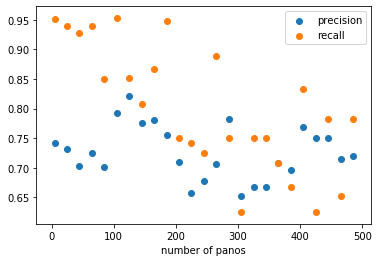

In [260]:
plt.figure()
plt.scatter(analysis_range, analysis_array[:, 0], label='precision')
plt.scatter(analysis_range, analysis_array[:, 1], label='recall')
plt.xlabel('number of panos')
plt.legend()

In [257]:
analysis_array[0, 2]

array([[ 14,  76],
       [ 11, 218]])

In [204]:
%%time
run_analysis(100)

CPU times: user 6.04 s, sys: 3.52 ms, total: 6.04 s
Wall time: 6.11 s


(0.7692307692307693, 0.6153846153846154, array([[15, 12],
        [25, 40]]))

In [206]:
%%time
run_analysis(100)

CPU times: user 5.48 s, sys: 12.6 ms, total: 5.5 s
Wall time: 5.54 s


(0.7719298245614035, 0.676923076923077, array([[14, 13],
        [21, 44]]))

In [208]:
%%time
run_analysis(100)

CPU times: user 27.5 s, sys: 23.6 ms, total: 27.5 s
Wall time: 27.8 s


(0.7636363636363637, 0.6461538461538462, array([[14, 13],
        [23, 42]]))

In [215]:
%%time
run_analysis(100)

CPU times: user 27.5 s, sys: 25.3 ms, total: 27.6 s
Wall time: 27.8 s


(0.7313432835820896, 0.7538461538461538, array([[ 9, 18],
        [16, 49]]))

In [222]:
%%time
run_analysis(100)

CPU times: user 36.9 s, sys: 27.4 ms, total: 37 s
Wall time: 37.3 s


(0.7464788732394366, 0.8153846153846154, array([[ 9, 18],
        [12, 53]]))

In [245]:
%%time
run_analysis(100)

CPU times: user 30.7 s, sys: 38.4 ms, total: 30.7 s
Wall time: 31.2 s


(0.7283950617283951, 0.9076923076923077, array([[ 5, 22],
        [ 6, 59]]))

In [246]:
%%time
run_analysis(100)

CPU times: user 21.7 s, sys: 43.1 ms, total: 21.8 s
Wall time: 22.1 s


(0.7534246575342466, 0.8461538461538461, array([[ 9, 18],
        [10, 55]]))